# Liesel-GAM Demo Notebook

## Setup and Imports

In [1]:
import jax.numpy as jnp
import liesel.goose as gs
import liesel.model as lsl
import tensorflow_probability.substrates.jax.distributions as tfd

import liesel_gam as gam

In [2]:
# import data from R
from ryp import r, to_py

r("library(mgcv)")
r("data(columb)")
r("data(columb.polys)")

columb = to_py("columb", format="pandas").reset_index()
polys = to_py("columb.polys", format="numpy")

Loading required package: nlme
This is mgcv 1.9-3. For overview type 'help("mgcv-package")'.


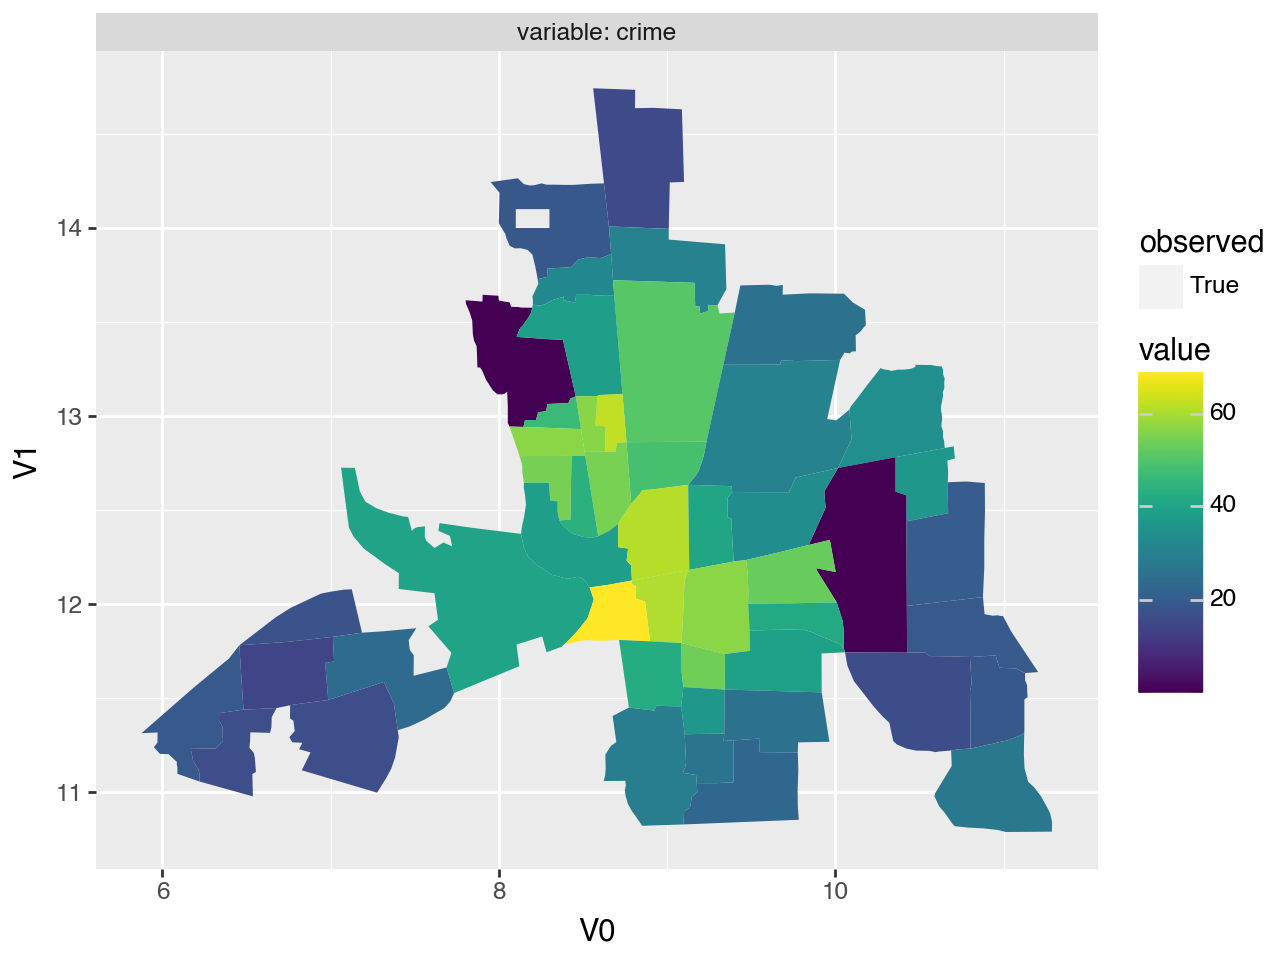

In [3]:
gam.plot_polys(region="district", which=["crime"], df=columb, polys=polys)

## Model Definition

### Setup response model

In [4]:
df = columb

loc = gam.AdditivePredictor("$\\mu$")
scale = gam.AdditivePredictor("$\\sigma$", inv_link=jnp.exp)


y = lsl.Var.new_obs(
    value=df.crime.to_numpy(),
    distribution=lsl.Dist(tfd.Normal, loc=loc, scale=scale),
    name="y",
)

tb = gam.TermBuilder.from_df(df)
loc += tb.mrf(
    "district",
    polys=polys,
    absorb_cons=True,
    diagonal_penalty=True,
    scale_penalty=True,
    noncentered=True,
)

### Build and plot model

liesel.model.model - INFO - Converted dtype of Value(name="y_value").value


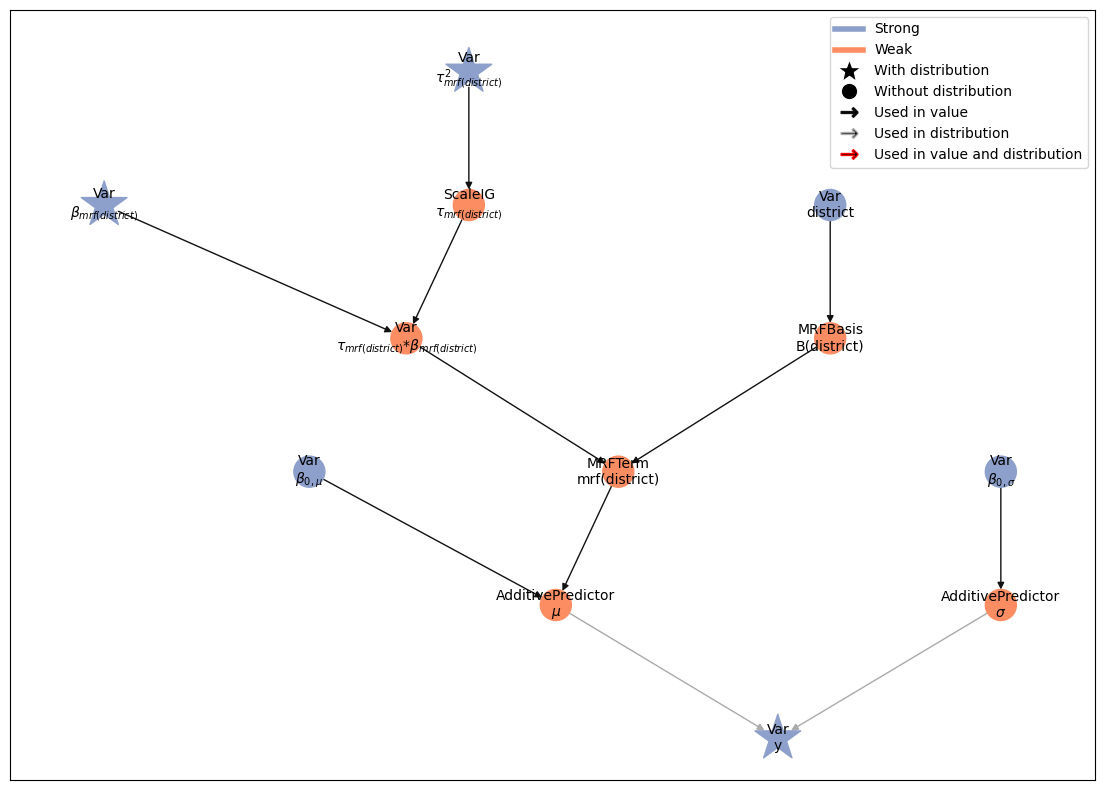

In [5]:
model = lsl.Model([y])
model.plot_vars()

## Run MCMC

In [6]:
eb = gs.LieselMCMC(model).get_engine_builder(seed=1, num_chains=4)

eb.set_epochs(
    gs.stan_epochs(
        warmup_duration=1000,
        posterior_duration=10000,
        init_duration=400,
        term_duration=400,
        thinning_posterior=10,
    )
)
engine = eb.build()
engine.sample_all_epochs()
results = engine.get_results()

liesel.goose.builder - WARNING - No jitter functions provided for position keys '$\\beta_{0,\\sigma}$', '$\\beta_{0,\\mu}$', '$\\beta_{mrf(district)}$', '$\\tau^2_{mrf(district)}$'. The initial values for these keys won't be jittered
liesel.goose.engine - INFO - Initializing kernels...
liesel.goose.engine - INFO - Done
liesel.goose.engine - INFO - Starting epoch: FAST_ADAPTATION, 400 transitions, 25 jitted together
100%|████████████████████████████████████████| 16/16 [00:03<00:00,  5.04chunk/s]
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 25 transitions, 25 jitted together
100%|█████████████████████████████████████████| 1/1 [00:00<00:00, 969.11chunk/s]
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 50 transitions, 25 jitted together
100%|████████████████████████████████████████| 2/2 [00:00<00:00, 1754.57chunk/s]
liesel.goose.engine - INFO - Finished epoch
liesel.goose

### MCMC summary

In [7]:
summary = gs.Summary(results)
summary

Parameter summary:

                                   kernel       mean        sd     q_0.05  \
parameter                index                                              
$\beta_{0,\mu}$          ()     kernel_01  35.100010  2.269369  31.331007   
$\beta_{0,\sigma}$       ()     kernel_00   2.723338  0.196032   2.325279   
$\beta_{mrf(district)}$  (0,)   kernel_02   0.167961  1.027246  -1.571002   
                         (1,)   kernel_02   0.008191  0.989158  -1.601740   
                         (2,)   kernel_02   0.138599  0.998428  -1.533754   
                         (3,)   kernel_02   0.193382  1.001791  -1.467915   
                         (4,)   kernel_02   0.065360  0.962253  -1.538736   
                         (5,)   kernel_02  -0.017591  0.963100  -1.584513   
                         (6,)   kernel_02  -0.075790  0.996593  -1.737007   
                         (7,)   kernel_02   0.025016  0.940433  -1.511745   
                         (8,)   kernel_02  -0.029265  0.970521  -1.614357   
                         (9,)   kernel_02   0.210666  1.033168  -1.494005   
                         (10,)  kernel_02   0.051629  0.976756  -1.530022   
                         (11,)  kernel_02  -0.048539  0.974233  -1.651250   
                         (12,)  kernel_02   0.015037  0.953244  -1.557121   
                         (13,)  kernel_02   0.000760  0.947824  -1.530431   
                         (14,)  kernel_02  -0.002260  0.961404  -1.557613   
                         (15,)  kernel_02  -0.206286  1.038617  -1.921884   
                         (16,)  kernel_02   0.057667  0.976653  -1.573844   
                         (17,)  kernel_02   0.034362  0.967458  -1.577527   
                         (18,)  kernel_02   0.074203  0.981668  -1.536849   
                         (19,)  kernel_02  -0.148905  0.989671  -1.753263   
                         (20,)  kernel_02   0.138786  0.963572  -1.467311   
                         (21,)  kernel_02   0.378102  1.076445  -1.386758   
                         (22,)  kernel_02   0.032414  0.957006  -1.569342   
                         (23,)  kernel_02  -0.077564  0.968358  -1.637096   
                         (24,)  kernel_02  -0.137690  1.002892  -1.748447   
                         (25,)  kernel_02   0.051734  0.956013  -1.496577   
                         (26,)  kernel_02  -0.093336  0.990711  -1.677529   
                         (27,)  kernel_02  -0.062651  0.964064  -1.648056   
                         (28,)  kernel_02  -0.149489  0.971929  -1.696016   
                         (29,)  kernel_02  -0.121031  0.979870  -1.687694   
                         (30,)  kernel_02   0.115292  0.971531  -1.537266   
                         (31,)  kernel_02  -0.094097  0.969639  -1.692212   
                         (32,)  kernel_02  -0.211376  1.001118  -1.811724   
                         (33,)  kernel_02   0.104152  0.975811  -1.516622   
                         (34,)  kernel_02  -0.129700  0.960901  -1.670515   
                         (35,)  kernel_02   0.173034  0.944131  -1.394303   
                         (36,)  kernel_02   0.193373  0.965429  -1.455206   
                         (37,)  kernel_02  -0.106141  0.962737  -1.661903   
                         (38,)  kernel_02  -0.069239  0.939595  -1.619094   
                         (39,)  kernel_02   0.227723  0.986345  -1.438936   
                         (40,)  kernel_02  -0.345882  1.006721  -1.897682   
                         (41,)  kernel_02   0.288142  0.977942  -1.401752   
                         (42,)  kernel_02  -0.417468  1.033322  -2.018588   
                         (43,)  kernel_02   0.257805  0.931141  -1.344636   
                         (44,)  kernel_02  -0.605433  1.065507  -2.171935   
                         (45,)  kernel_02  -0.669671  1.082282  -2.265942   
                         (46,)  kernel_02  -0.244762  0.890468  -1.639922   
                         (47,)  kernel_02   0.579048 

## Plots

In [8]:
samples = results.get_posterior_samples()

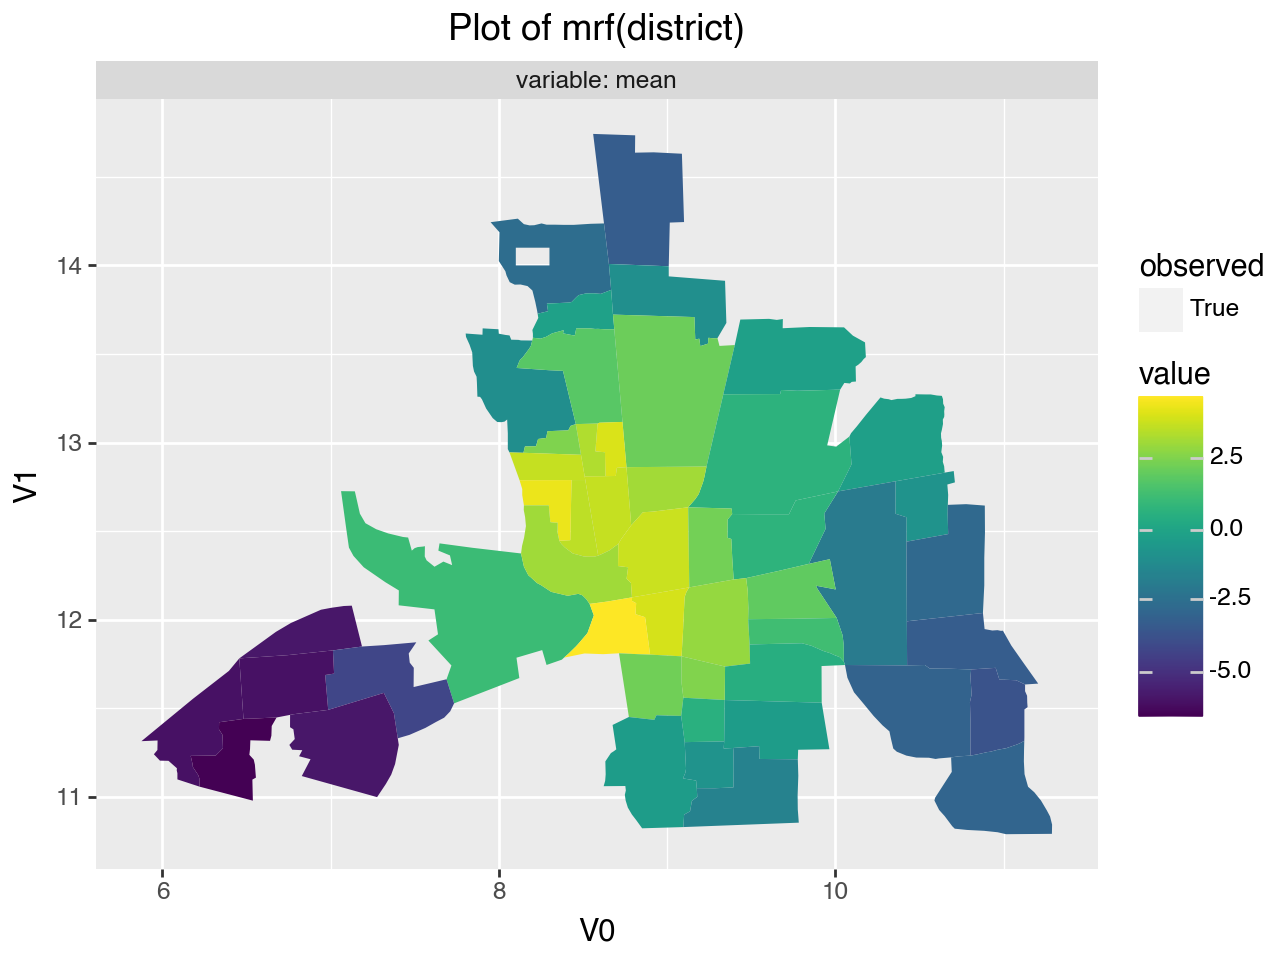

In [9]:
gam.plot_regions(
    term=loc.terms["mrf(district)"],
    samples=samples,
    # polys=polys, # since the term was created with polygons, no need to supply them
)

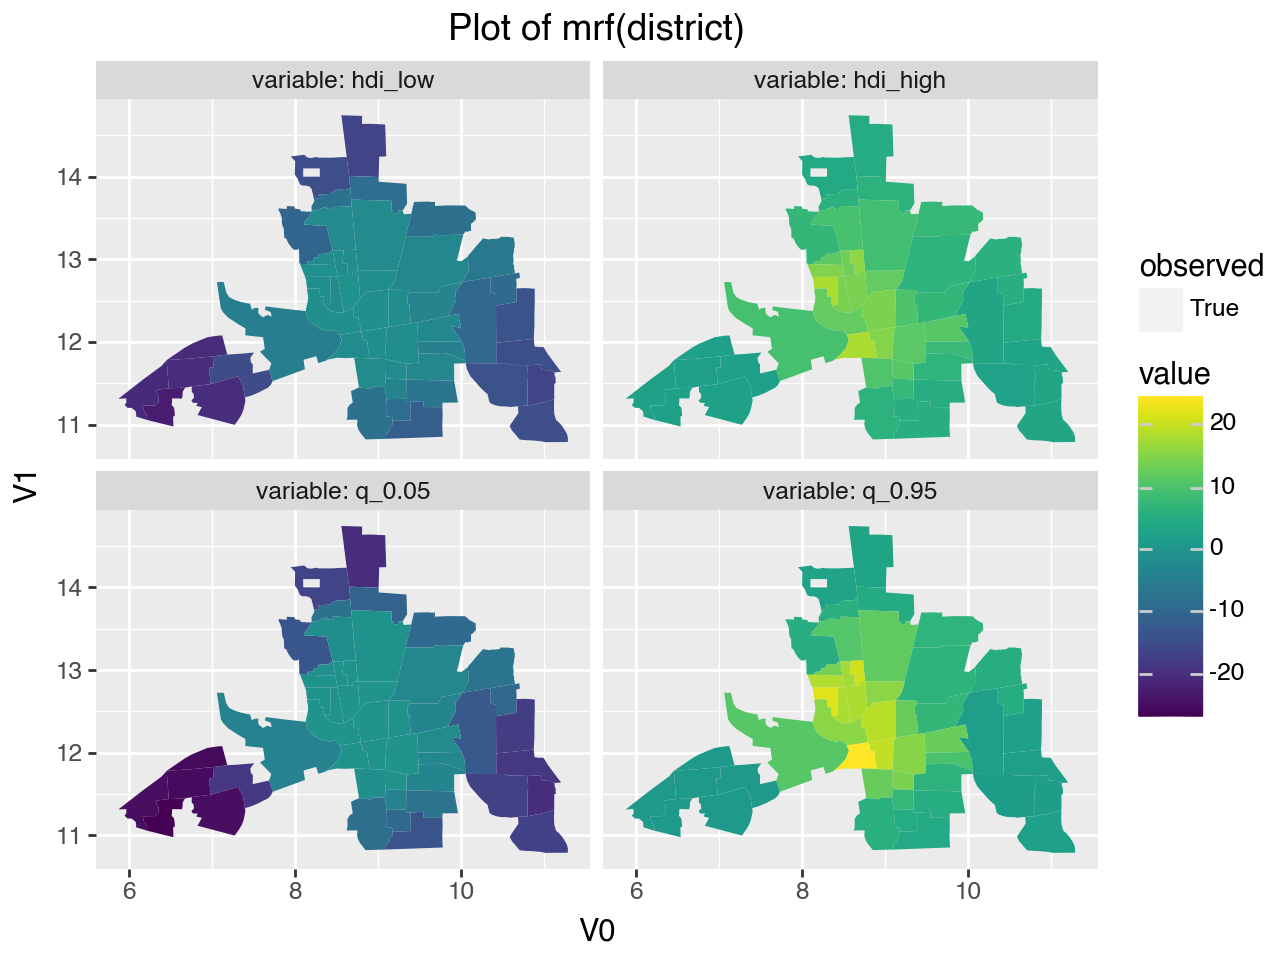

In [10]:
gam.plot_regions(
    term=loc.terms["mrf(district)"],
    samples=samples,
    # polys=polys, # since the term was created with polygons, no need to supply them
    which=["hdi_low", "hdi_high", "q_0.05", "q_0.95"],
)

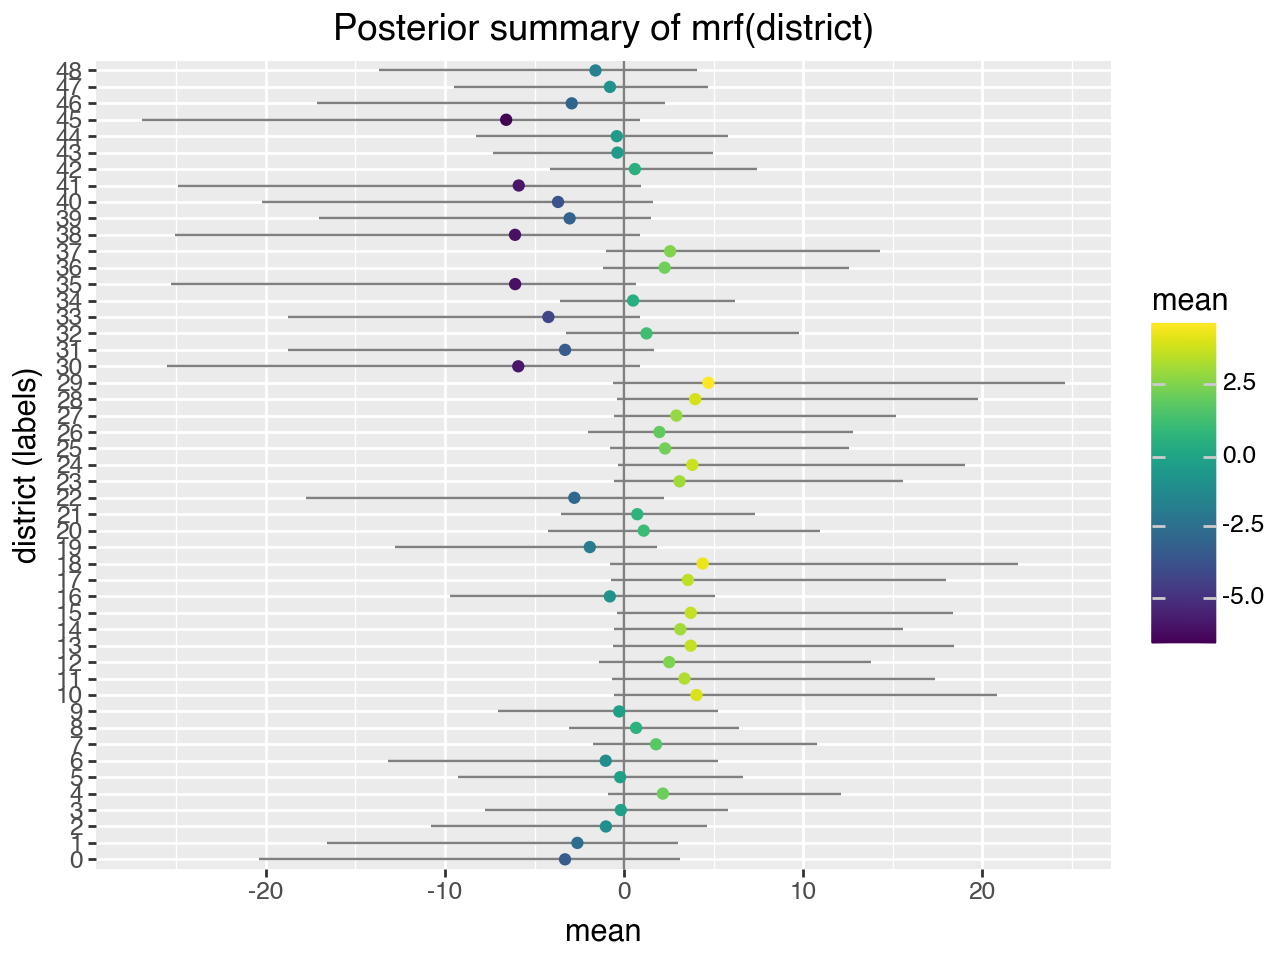

In [ ]:
import plotnine as p9

gam.plot_forest(
    term=loc.terms["mrf(district)"],
    samples=samples,
    # labels=tb.bases.mappings["district"],
    ymin="q_0.05",
    ymax="q_0.95",
) + p9.aes(color="mean")